In [1]:
# Install dependencies
!pip install -q torch torchvision opencv-python matplotlib
!pip install -q git+https://github.com/IDEA-Research/GroundingDINO.git

# Clone repository and download model
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
# Download the SwinB model with the correct URL
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth
# Set up paths
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.1 MB/s eta 0:00:00
   

In [ ]:
# Check if the file exists in the repository structure
!find GroundingDINO -name "*.pth"

#cleaned up code

Please upload an image for object detection:


Saving 22115.png to 22115 (1).png
Using uploaded file: 22115 (1).png

Using device: cpu

Starting detection for prompts: 'sump, plant pot, bowl, bucket, empty container, human, water puddle, metal pot, blue container, barrel, plastic barrel with a lid, plastic drum, plastic container, large container, sink'
Loading GroundingDINO SwinT...
final text_encoder_type: bert-base-uncased
Running GroundingDINO SwinT prediction...
GroundingDINO SwinT found 0 potential objects.

Loading GroundingDINO SwinB...
final text_encoder_type: bert-base-uncased
Running GroundingDINO SwinB prediction...
GroundingDINO SwinB found 0 potential objects.

Running OWL-ViT prediction...
OWL-ViT found 1 potential objects.

Merging results...
Total unique objects after merging: 1

--- Detection Summary ---
Found 1 unique objects matching the prompt:
- barrel (Confidence: 0.211) @ Box: [0.350, 0.455, 0.819, 1.001]
------------------------



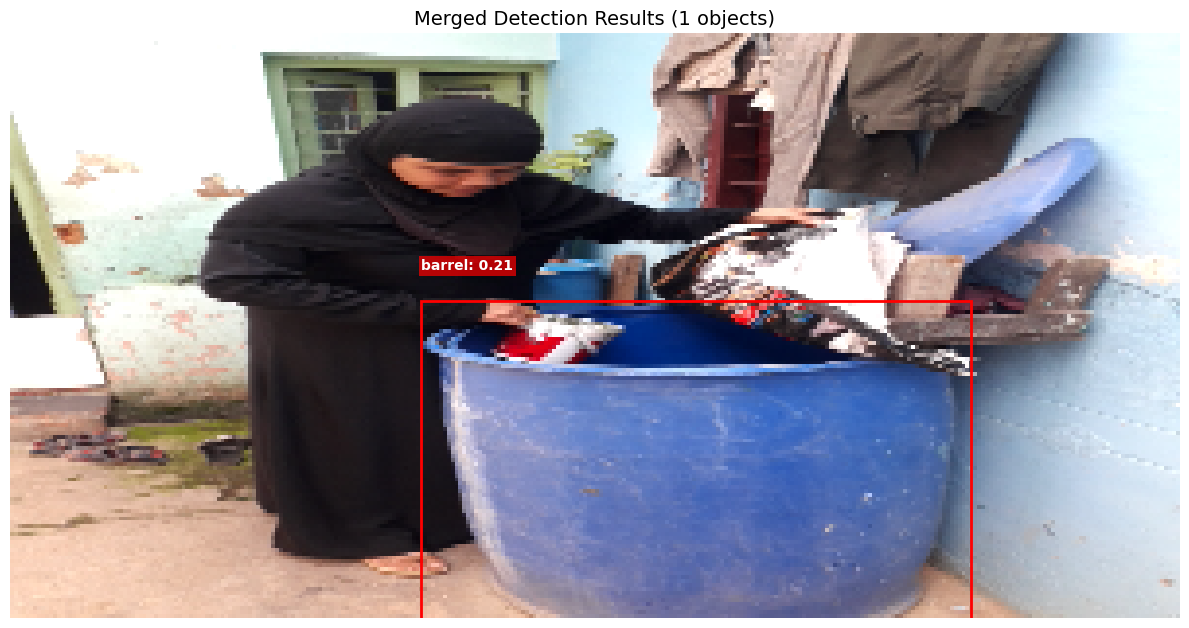

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import warnings

try:
    from google.colab import files
    IS_COLAB = True
except ImportError:
    IS_COLAB = False
    print("Not running in Google Colab. File upload will be skipped.")
    print("Please modify the 'run_multi_model_detection' function to load images differently.")

from transformers import OwlViTProcessor, OwlViTForObjectDetection
from torchvision.ops import nms

# --- GroundingDINO specific import ---
try:
    from groundingdino.util.inference import load_model, predict as groundingdino_predict
except ImportError:
    print("ERROR: GroundingDINO library not found or prerequisites not met.")
    print("Please ensure you have run the prerequisite steps (pip install, git clone, wget).")
    def groundingdino_predict(*args, **kwargs):
        warnings.warn("GroundingDINO predict function not loaded. Returning empty results.")
        return torch.zeros((0, 4)), torch.zeros(0), []
    def load_model(*args, **kwargs):
        warnings.warn("GroundingDINO load_model function not loaded. Returning None.")
        return None

# --- Helper Functions ---

def owl_vit_detect(image_np, text_prompt, threshold=0.1, device="cpu"):
    try:
        processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
        model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)
        model.eval()
    except Exception as e:
        print(f"Error loading OWL-ViT model: {e}")
        return torch.zeros((0, 4)), torch.zeros(0), []

    if isinstance(text_prompt, str):
        texts = [t.strip() for t in text_prompt.split(',') if t.strip()]
    else:
        texts = [str(t).strip() for t in text_prompt if str(t).strip()]

    if not texts:
        print("Warning: No valid text prompts provided for OWL-ViT.")
        return torch.zeros((0, 4)), torch.zeros(0), []

    image_pil = Image.fromarray(image_np)
    inputs = processor(text=texts, images=image_pil, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image_pil.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]

    boxes = results["boxes"]
    scores = results["scores"]
    labels = results["labels"]

    keep = scores > threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    img_h, img_w = image_np.shape[:2]
    scale_fct = torch.tensor([img_w, img_h, img_w, img_h]).to(device)
    norm_boxes = boxes / scale_fct

    phrases = [texts[i] for i in labels]

    norm_boxes = norm_boxes.cpu()
    scores = scores.cpu()

    return norm_boxes, scores, phrases


def merge_detection_results(results_list, iou_threshold=0.5):
    all_boxes = []
    all_scores = []
    all_phrases_indices = []
    original_phrases = []

    current_phrase_index = 0
    for boxes, scores, phrases in results_list:
        if boxes is not None and len(boxes) > 0:
            all_boxes.append(boxes.cpu())
            all_scores.append(scores.cpu())
            indices = list(range(current_phrase_index, current_phrase_index + len(phrases)))
            all_phrases_indices.extend(indices)
            original_phrases.extend(phrases)
            current_phrase_index += len(phrases)

    if not all_boxes:
        return torch.zeros((0, 4)), torch.zeros(0), []

    all_boxes_cat = torch.cat(all_boxes, dim=0)
    all_scores_cat = torch.cat(all_scores, dim=0)

    if len(all_boxes_cat) > 0:
        keep_indices = nms(all_boxes_cat, all_scores_cat, iou_threshold)
        merged_boxes = all_boxes_cat[keep_indices]
        merged_scores = all_scores_cat[keep_indices]
        original_indices_kept = [all_phrases_indices[i] for i in keep_indices]
        merged_phrases = [original_phrases[i] for i in original_indices_kept]
    else:
        merged_boxes = all_boxes_cat
        merged_scores = all_scores_cat
        merged_phrases = []

    return merged_boxes, merged_scores, merged_phrases


def multi_model_detect(image_np, text_prompt, device="cpu"):
    results_list = []

    grounding_dino_repo_path = "GroundingDINO"
    gd_swint_config = f"{grounding_dino_repo_path}/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    gd_swint_checkpoint = "groundingdino_swint_ogc.pth"
    gd_swinb_config = f"{grounding_dino_repo_path}/groundingdino/config/GroundingDINO_SwinB_cfg.py"
    gd_swinb_checkpoint = "groundingdino_swinb_cogcoor.pth"

    box_threshold = 0.35
    text_threshold = 0.25

    print("Loading GroundingDINO SwinT...")
    groundingdino_swint_model = load_model(gd_swint_config, gd_swint_checkpoint, device=device)
    if groundingdino_swint_model:
        print("Running GroundingDINO SwinT prediction...")
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float()
        with torch.no_grad():
            boxes_swint, logits_swint, phrases_swint = groundingdino_predict(
                model=groundingdino_swint_model,
                image=image_tensor,
                caption=text_prompt,
                box_threshold=box_threshold,
                text_threshold=text_threshold,
                device=device
            )
        print(f"GroundingDINO SwinT found {len(boxes_swint)} potential objects.")
        results_list.append((boxes_swint.cpu(), logits_swint.cpu(), phrases_swint))
        del groundingdino_swint_model
        torch.cuda.empty_cache() if device == 'cuda' else None
    else:
        print("Skipping GroundingDINO SwinT.")

    print("\nLoading GroundingDINO SwinB...")
    try:
        groundingdino_swinb_model = load_model(gd_swinb_config, gd_swinb_checkpoint, device=device)
        use_swinb = True
    except Exception as e:
        print(f"Could not load GroundingDINO SwinB model: {e}. Skipping.")
        groundingdino_swinb_model = None
        use_swinb = False

    if use_swinb and groundingdino_swinb_model:
        print("Running GroundingDINO SwinB prediction...")
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float()
        with torch.no_grad():
            boxes_swinb, logits_swinb, phrases_swinb = groundingdino_predict(
                model=groundingdino_swinb_model,
                image=image_tensor,
                caption=text_prompt,
                box_threshold=box_threshold,
                text_threshold=text_threshold,
                device=device
            )
        print(f"GroundingDINO SwinB found {len(boxes_swinb)} potential objects.")
        results_list.append((boxes_swinb.cpu(), logits_swinb.cpu(), phrases_swinb))
        del groundingdino_swinb_model
        torch.cuda.empty_cache() if device == 'cuda' else None

    print("\nRunning OWL-ViT prediction...")
    try:
        boxes_owl, scores_owl, phrases_owl = owl_vit_detect(
            image_np=image_np,
            text_prompt=text_prompt,
            threshold=0.1,
            device=device
        )
        print(f"OWL-ViT found {len(boxes_owl)} potential objects.")
        results_list.append((boxes_owl.cpu(), scores_owl.cpu(), phrases_owl))
        torch.cuda.empty_cache() if device == 'cuda' else None
    except Exception as e:
        print(f"OWL-ViT detection failed: {e}")

    print("\nMerging results...")
    merged_boxes, merged_scores, merged_phrases = merge_detection_results(results_list, iou_threshold=0.5)
    print(f"Total unique objects after merging: {len(merged_boxes)}")

    return merged_boxes, merged_scores, merged_phrases


def visualize_detections(image_np, boxes, scores, phrases):
    if boxes is None or len(boxes) == 0:
        print("No detections to visualize.")
        plt.figure(figsize=(10, 10))
        plt.imshow(image_np)
        plt.title("No objects detected")
        plt.axis('off')
        plt.show()
        return

    img_height, img_width = image_np.shape[:2]

    plt.figure(figsize=(12, 10), facecolor='white')
    plt.imshow(image_np)
    ax = plt.gca()
    ax.set_axis_off()

    boxes = boxes.cpu()
    scores = scores.cpu()

    for i, (box, score, phrase) in enumerate(zip(boxes, scores, phrases)):
        box_np = box.numpy()
        x1, y1, x2, y2 = box_np
        abs_x1 = x1 * img_width
        abs_y1 = y1 * img_height
        abs_x2 = x2 * img_width
        abs_y2 = y2 * img_height
        box_w = abs_x2 - abs_x1
        box_h = abs_y2 - abs_y1

        rect = plt.Rectangle(
            (abs_x1, abs_y1), box_w, box_h,
            fill=False,
            edgecolor='red',
            linewidth=2
        )
        ax.add_patch(rect)

        label = f"{phrase}: {score:.2f}"
        ax.text(
            abs_x1, abs_y1 - 8,
            label,
            color='white',
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='red', alpha=0.7, pad=2, edgecolor='none')
        )

    plt.title(f"Merged Detection Results ({len(boxes)} objects)", fontsize=14)
    plt.tight_layout()
    plt.show()


def run_multi_model_detection(image_path=None):
    local_image_path = None
    if image_path:
        local_image_path = image_path
        print(f"Loading image from path: {local_image_path}")
    elif IS_COLAB:
        print("Please upload an image for object detection:")
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded. Exiting.")
            return
        local_image_path = next(iter(uploaded))
        print(f"Using uploaded file: {local_image_path}")
    else:
        print("Error: No image path provided and not running in Colab.")
        print("Please provide the 'image_path' argument to 'run_multi_model_detection'.")
        return

    try:
        image_np = cv2.imread(local_image_path)
        if image_np is None:
             raise IOError(f"Could not read image file: {local_image_path}")
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    TEXT_PROMPT = """
    sump, plant pot, bowl, bucket, empty container, human, water puddle,
    metal pot, blue container, barrel, plastic barrel with a lid,
    plastic drum, plastic container, large container, sink
    """
    TEXT_PROMPT = ", ".join([p.strip() for p in TEXT_PROMPT.strip().split(',') if p.strip()])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")
    if device == 'cpu':
        warnings.warn("CUDA not available, running on CPU. This might be slow.")

    print(f"\nStarting detection for prompts: '{TEXT_PROMPT}'")
    merged_boxes, merged_scores, merged_phrases = multi_model_detect(
        image_np, TEXT_PROMPT, device
    )

    print("\n--- Detection Summary ---")
    print(f"Found {len(merged_boxes)} unique objects matching the prompt:")
    if len(merged_boxes) > 0:
      sorted_indices = torch.argsort(merged_scores, descending=True)
      for i in sorted_indices:
          box = merged_boxes[i]
          score = merged_scores[i]
          phrase = merged_phrases[i]
          box_coords = [f"{coord:.3f}" for coord in box.tolist()]
          print(f"- {phrase} (Confidence: {score:.3f}) @ Box: [{', '.join(box_coords)}]")
    else:
        print("No objects detected.")
    print("------------------------\n")

    visualize_detections(image_np, merged_boxes, merged_scores, merged_phrases)

# --- Execution ---
if __name__ == "__main__":
    # How to run:
    # 1. If in Colab, just run the cell containing this script. It will prompt for upload.
    # 2. If running locally:
    #    - Make sure prerequisites are met (packages installed, repo cloned, models downloaded).
    #    - Change 'your_image.jpg' to the actual path of your image file.
    #    - Run the script: python your_script_name.py

    # Example for local execution (uncomment and modify path):
    # run_multi_model_detection(image_path='path/to/your_image.jpg')

    # Default behavior (Colab upload or error if not Colab and no path given)
    run_multi_model_detection()